In [ ]:
pip install yfinance ccxt numpy pandas scipy matplotlib QuantLib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.9/117.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.6/19.6 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.6/288.6 kB 23.8 MB/s eta 0:00:00
  Attempting uninstall: aiohttp
    Found existing installation: aiohttp 3.11.10
    Uninstalling aiohttp-3.11.10:
      Successfully uninstalled aiohttp-3.11.10


In [80]:
from IPython.display import display
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np

In [81]:


def option_chains(ticker):
    """
    """
    asset = yf.Ticker(ticker)
    expirations = asset.options

    chains = pd.DataFrame()

    for expiration in expirations:
        # Fetch option chain for the specific expiration date
        opt = asset.option_chain(expiration)

        # Process calls
        calls = opt.calls
        calls['optionType'] = "call"

        # Process puts
        puts = opt.puts
        puts['optionType'] = "put"

        # Combine calls and puts
        chain = pd.concat([calls, puts])
        chain['expiration'] = pd.to_datetime(expiration) + pd.DateOffset(hours=23, minutes=59, seconds=59)

        # Append to the overall chains DataFrame
        chains = pd.concat([chains, chain])

    # Calculate days to expiration
    chains["daysToExpiration"] = (chains.expiration - pd.Timestamp.now()).dt.days + 1

    return chains


In [82]:
options = option_chains("SPY")
calls = options[options["optionType"] == "call"]

<Axes: title={'center': 'Implied Volatility Skew'}, xlabel='strike'>

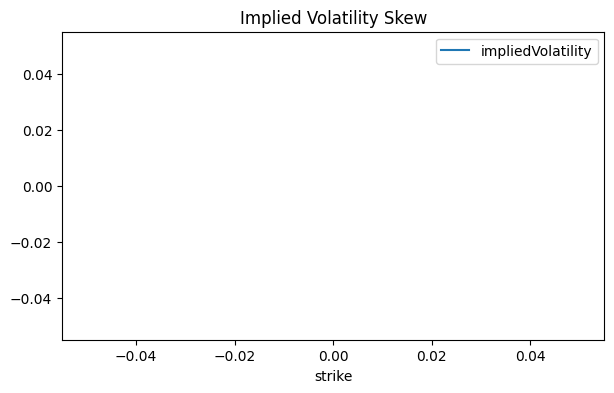

In [83]:

set(calls.expiration)
calls_at_expiry = calls[calls["expiration"] == "2023-01-20 23:59:59"]
filtered_calls_at_expiry = calls_at_expiry[calls_at_expiry.impliedVolatility >= 0.001]
filtered_calls_at_expiry[["strike", "impliedVolatility"]].set_index("strike").plot(
    title= "Implied Volatility Skew", figsize=(7,4)
    )

<Axes: title={'center': 'Implied Volatility term structure'}, xlabel='expiration'>

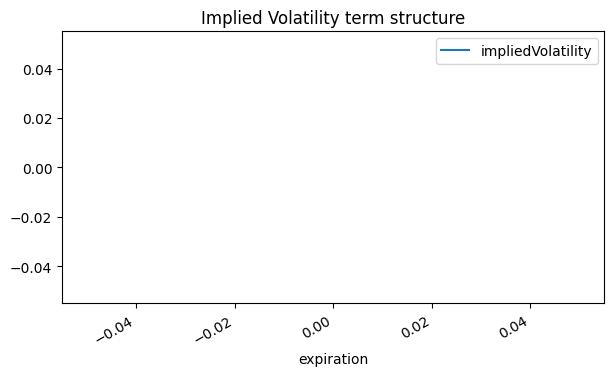

In [84]:
call_at_strike = options[options["strike"] == "400.0"]
filtered_call_at_strike =call_at_strike[call_at_strike.impliedVolatility >= 0.001]
filtered_call_at_strike[["expiration", "impliedVolatility"]].set_index("expiration").plot(
    title="Implied Volatility term structure", figsize=(7, 4)
    )

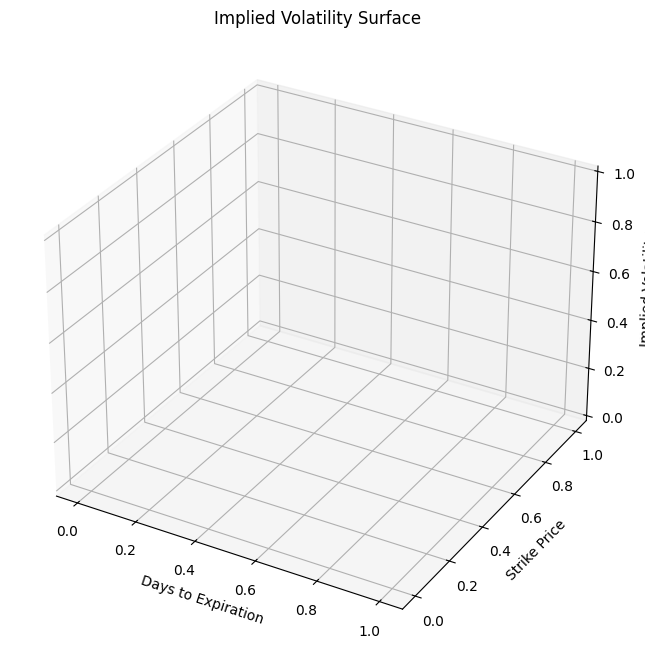

In [85]:
surface = (
    calls[['daysToExpiration', 'strike', 'impliedVolatility']]
    .pivot_table(values='daysToExpiration', index='strike', columns='impliedVolatility')
    .dropna()
)
fig = plt.figure(figsize = (10,8) )
ax =fig.add_subplot(111,projection = '3d')

x,y,z = surface.columns.values , surface.index.values, surface.values
X,Y = np.meshgrid(x,y)
ax.set_xlabel('Days to Expiration')
ax.set_ylabel('Strike Price')
ax.set_zlabel('Implied Volatility')
ax.set_title('Implied Volatility Surface')
ax.plot_surface(X,Y,z)